# Notebook 3: Data Cleaning & Train/Test Preparation

---

## 🎯 Objectives
In this notebook, we will take the raw dataset from **Notebook 1** and the insights from **Notebook 2** to prepare a **clean, encoded, and split dataset** ready for modelling.  
We will:
- Address missing values and invalid entries.
- Apply categorical encoding where necessary.
- Create train/test datasets for modelling.
- Save cleaned datasets for later use.

---

## 📂 Inputs & Outputs

**Inputs**
- `heart_disease_raw.csv` (saved from Notebook 1)

**Outputs**
- `TrainSetCleaned.csv` (clean training data)
- `TestSetCleaned.csv` (clean test data)

---

## Load Raw Dataset

Step Purpose

We begin by loading the unmodified dataset saved in **Notebook 1**. This ensures that cleaning steps are reproducible and independent from exploratory work.

Approach

- Use `pd.read_csv()` to load the dataset.
- Display shape and first few rows to confirm load.

Expected Outcome

Dataset loaded with no changes, matching exactly the saved raw version.

In [2]:
import pandas as pd
from pathlib import Path

input_path = Path("/workspaces/Heart_disease_risk_predictor/inputs/datasets/raw/heart_disease_uci.csv")
df = pd.read_csv(input_path)

print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
df.head()

Dataset loaded: 920 rows × 16 columns


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


---

## Step 2.5 — Re-check Missingness After Replacing Invalid Zeros

Before deciding whether to drop or impute, we need to make sure that our missingness statistics reflect reality.  
In this dataset, some features (like `trestbps` and `chol`) have **invalid zero values**.  
We first replace those zeros with `NaN`, then recalculate missing percentages.

This lets us:
- Identify which features are safe to impute,  
- Which ones require caution, and  
- Which ones should be dropped due to too much missing data.  

We also visualize the distribution of missing values by column, color-coded by severity:

- Green = Safe to impute (≤ 5%)  
- Orange = Caution (5–25%)  
- Red = Likely drop (> 25%)  

✅ Low missing (<=5%) — safe to impute:
 restecg    0.217391
age        0.000000
id         0.000000
sex        0.000000
dataset    0.000000
cp         0.000000
num        0.000000
dtype: float64 

⚠️ Medium missing (5–25%) — caution:
 chol        21.956522
fbs          9.782609
oldpeak      6.739130
trestbps     6.521739
thalch       5.978261
exang        5.978261
dtype: float64 

❌ High missing (>25%) — consider dropping:
 ca       66.413043
thal     52.826087
slope    33.586957
dtype: float64 



/tmp/ipykernel_658/3949064940.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


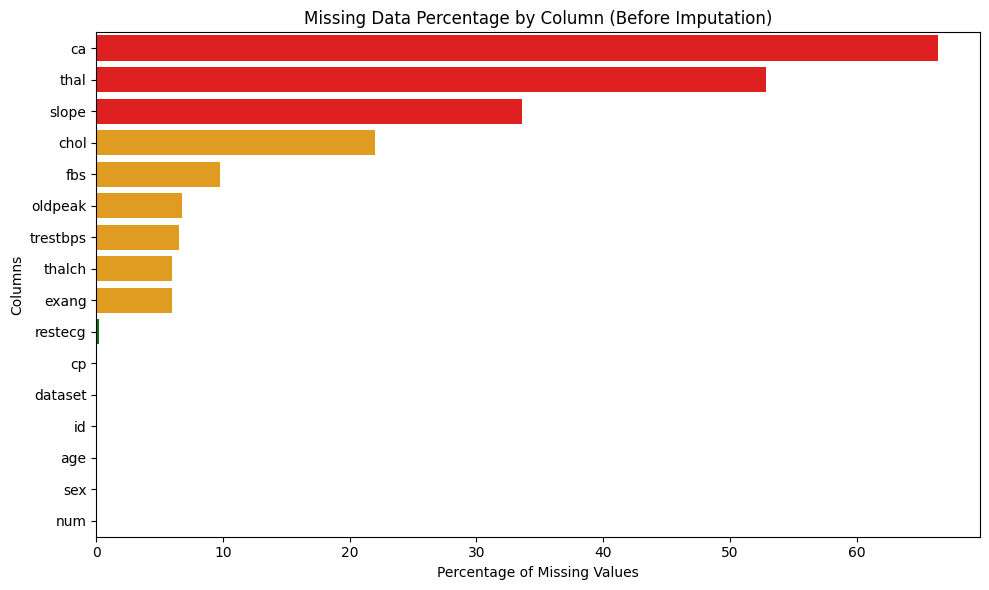

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Replace invalid zeros (do this once, before missingness decisions) ---
for col in ['trestbps', 'chol']:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

# --- BEFORE-IMPUTATION CHECK: % missing values ---
missing_percent = (df.isna().sum() / len(df)) * 100

# Policy thresholds
low_threshold = 5      # Safe to impute
high_threshold = 25    # Drop above this (unless whitelisted)

# Buckets
low_missing    = missing_percent[missing_percent <= low_threshold]
medium_missing = missing_percent[(missing_percent > low_threshold) & (missing_percent <= high_threshold)]
high_missing   = missing_percent[missing_percent > high_threshold]

print("✅ Low missing (<=5%) — safe to impute:\n", low_missing.sort_values(ascending=False), "\n")
print("⚠️ Medium missing (5–25%) — caution:\n", medium_missing.sort_values(ascending=False), "\n")
print("❌ High missing (>25%) — consider dropping:\n", high_missing.sort_values(ascending=False), "\n")

# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))
ordered = missing_percent.sort_values(ascending=False)
sns.barplot(
    x=ordered.values,
    y=ordered.index,
    palette=[
        "red" if val > high_threshold else "orange" if val > low_threshold else "green"
        for val in ordered.values
    ]
)
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Columns")
plt.title("Missing Data Percentage by Column (Before Imputation)")
plt.tight_layout()
plt.show()

---

## Step 3 — Drop or Keep Columns Based on Missingness Policy

We now apply a **decision policy** to each feature:

- **Drop features** if missing > 25% (too unreliable for imputation).  
- **Keep and impute** if ≤ 25%.  
- **Allow exceptions**: Some features (like `chol`) are too clinically important to discard, even if missingness is borderline. These are *whitelisted* in a `force_keep` list.

This balances:
- Preserving medically valuable predictors,  
- Avoiding unrealistic imputation of large data gaps.  

In [4]:
# Columns to DROP (missing% > 25), unless explicitly protected
to_drop = set(high_missing.index.tolist())

# Explicit exceptions to KEEP (force whitelist)
force_keep = {"chol"}

# Apply whitelist
to_drop = [c for c in to_drop if c not in force_keep]

print(f"Columns to DROP (> {high_threshold}% missing, excluding exceptions): {to_drop}")

# Drop them
df = df.drop(columns=to_drop)

Columns to DROP (> 25% missing, excluding exceptions): ['thal', 'ca', 'slope']


---

## Step 4 — Impute Missing Values in Remaining Columns

After dropping high-missing features, we handle missing values in the remaining columns:  

- **Numeric features** → imputed with the **median** (robust against skew/outliers).  
- **Categorical features** → imputed with the **mode** (most frequent value).  

We re-check missingness after imputation to ensure that the dataset has no `NaN` values left.  

In [6]:
# Recompute missing after drops
missing_percent_postdrop = (df.isna().sum() / len(df)) * 100
remaining_missing_cols = missing_percent_postdrop[missing_percent_postdrop > 0].index.tolist()

# Split numeric vs categorical
num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(exclude='number').columns.tolist()

# Exclude target column 'num' from imputation
if 'num' in num_cols:
    num_cols_wo_target = [c for c in num_cols if c != 'num']
else:
    num_cols_wo_target = num_cols[:]

# Impute
for col in remaining_missing_cols:
    if col in num_cols_wo_target:
        df[col] = df[col].fillna(df[col].median())
    elif col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Confirm no NaNs remain
print("Remaining missing after imputation:\n", df.isna().sum().sort_values(ascending=False))

Remaining missing after imputation:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64


---

## Step 5 — Encode Categorical Variables

Machine learning models require numerical input.  
We therefore convert categorical features into **dummy variables** using **one-hot encoding**:

- Each category becomes a new binary column (1 if present, 0 if not).  
- We use `drop_first=True` to avoid dummy-variable trap (perfect collinearity).  

The target column `num` is **not encoded** — it remains intact for modeling. 

In [7]:
# Identify categorical variables
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

---

## Replace Invalid Zeros with NaN

Step Purpose

Medical context:

- trestbps = resting blood pressure (mm Hg) → cannot be 0 in a living patient.

- chol = serum cholesterol (mg/dl) → cannot be 0.

Zeros are often placeholders for "missing" in datasets. We replace them with NaN for correct handling.

*Approach

- Use df[col].replace(0, np.nan) for identified variables.

* Expected Outcome

Invalid zeros replaced with NaN so they can be correctly imputed or handled.

In [12]:
import numpy as np

for col in ['trestbps', 'chol']:
    df[col] = df[col].replace(0, np.nan)

df[['trestbps', 'chol']].isin([0]).sum()

trestbps    0
chol        0
dtype: int64

---

# Impute or Drop Missing Data

Step Purpose

Missing values can reduce model accuracy and cause errors.
We must decide whether to:

- Impute (replace with median, mode, etc.)

- Drop variables (if too many missing values)

- Drop rows (if few and random)

Approach

- Check % missing for each column.

- For continuous variables (e.g., trestbps, chol), impute with median.

- For categorical (e.g., ca, thal), impute with mode.

Expected Outcome

A complete dataset with no missing values.

In [8]:
missing_percent = (df.isna().sum() / len(df)) * 100
print(missing_percent)

# Impute numerics with median
num_cols = df.select_dtypes(include='number').columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Impute categoricals with mode
cat_cols = df.select_dtypes(exclude='number').columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

id           0.000000
age          0.000000
sex          0.000000
dataset      0.000000
cp           0.000000
trestbps     6.521739
chol        21.956522
fbs          9.782609
restecg      0.217391
thalch       5.978261
exang        5.978261
oldpeak      6.739130
slope       33.586957
ca          66.413043
thal        52.826087
num          0.000000
dtype: float64


---

# Encode Categorical Variables

Step Purpose

Machine learning algorithms generally require numerical inputs.
We convert categorical variables into numbers without losing meaning.

Approach

- Use pd.get_dummies() for one-hot encoding.

- Drop first category to avoid dummy variable trap.

Expected Outcome

All features are numeric and ready for modelling.

In [9]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,id,age,trestbps,chol,fbs,thalch,exang,oldpeak,ca,num,...,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,1,63,145.0,233.0,True,150.0,False,2.3,0.0,0,...,False,False,False,True,False,False,False,False,False,False
1,2,67,160.0,286.0,False,108.0,True,1.5,3.0,2,...,False,False,False,False,False,False,True,False,True,False
2,3,67,120.0,229.0,False,129.0,True,2.6,2.0,1,...,False,False,False,False,False,False,True,False,False,True
3,4,37,130.0,250.0,False,187.0,False,3.5,0.0,0,...,False,False,True,False,True,False,False,False,True,False
4,5,41,130.0,204.0,False,172.0,False,1.4,0.0,0,...,False,True,False,False,False,False,False,True,True,False
